In [1]:
from transformers import Blip2Processor, AutoTokenizer
from src.models.processor import SurroundBlipImageProcessor

model_name = "Salesforce/blip2-opt-2.7b" 
# processor = SurroundBlipImageProcessor.from_pretrained(model_name)
# processor = Blip2Processor.from_pretrained(model_name)
# processor.image_processor = SurroundBlipImageProcessor.from_pretrained(model_name)
# print(processor.tokenizer.pad_token_id)
PAD_TOKEN_ID = 1

c:\Users\Seungwoo\.conda\envs\surr\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-05-20 23:22:31,152] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


W0520 23:22:31.780000 24808 torch\distributed\elastic\multiprocessing\redirects.py:27] NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
from transformers import AutoImageProcessor, AutoTokenizer, LlavaNextProcessor

image_processor = AutoImageProcessor.from_pretrained("google/siglip-base-patch16-224")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [2]:
from py360convert import e2p
import torch
from torch.utils.data import Dataset, DataLoader
from typing import Dict, List, Optional, Union
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
from pathlib import Path
import pandas as pd
import numpy as np
# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터셋 경로 설정
data_dir = Path("data/quic360")

In [3]:
# 데이터셋 클래스 정의
class QuIC360Dataset(Dataset):
    def __init__(self, 
                 csv_file: str,
                 model_name: str = "Salesforce/blip2-opt-2.7b" ,
                 image_size: list = [224,224],
                 max_length: Optional[int] = None,
                 split: str = "train",
                 do_crop: bool = False,
                 fov: Optional[float] = None,
                 overlap_ratio: Optional[float] = None,
                 transform: bool = False):
        super().__init__()
        
        self.df = pd.read_csv(csv_file)
        self.processor = Blip2Processor.from_pretrained(model_name)
        
        self.max_length = max_length
        self.split = split
        self.do_crop = do_crop
        if self.do_crop:
            self.image_size = (int(image_size[0] * 2), int(image_size[1] * 4))
            self.fov = fov
            self.overlap_ratio = overlap_ratio
        else:
            self.image_size = tuple(image_size)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx: int) -> Dict[str, Union[torch.Tensor, str]]:
        # 이미지 경로와 질문, 정답을 가져옵니다.
        image_path = self.df.iloc[idx]["url"]
        question = str(self.df.iloc[idx]["query"])
        answer = str(self.df.iloc[idx]["annotation"])
        
        
        # 이미지를 로드합니다.
        image = Image.open(image_path).convert("RGB")
        inputs = self.processor(
                text=question,
                images=image,
                size=self.image_size,
                return_tensors="pt",
                max_length=self.max_length,
                padding="max_length",
                truncation=True,
            )
        # qtext = f"Question: {question} Answer:"
        # 질문과 정답을 전처리합니다.
        if self.do_crop:
            inputs["pixel_values"] = self.crop_equirectangular_tensor(inputs["pixel_values"])
        
        # 정답을 전처리합니다.
        answers = self.processor(
            text=answer,
            return_tensors="pt",
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
        )
        
        # Hugging Face Trainer가 기대하는 평평한 구조로 반환
        return {
            "pixel_values": inputs["pixel_values"].squeeze(0),  # (Num Crops ,C, H, W)
            "input_ids": inputs["input_ids"].squeeze(0),        # (L1)
            "attention_mask": inputs["attention_mask"].squeeze(0),  # (L1)
            "labels": answers["input_ids"].squeeze(0),          # (L2)
            "image_path": image_path,
            "question": question,
            "answer": answer
        }

    def crop_equirectangular_tensor(self, img_tensor: torch.Tensor,
                                    fov: float = 90.0, overlap_ratio: float = 0.5):
        B, C, H2, W4 = img_tensor.shape
        assert B == 1
        H, W = H2 // 2, W4 // 4

        # 1) stride 각도
        step = fov * (1.0 - overlap_ratio)

        # 2) 필요한 패치 개수
        num_patches = int(np.ceil(360.0 / step))

        # 3) 0도부터 시작해 step 간격으로 중심 각 생성
        yaw_centers = (np.arange(num_patches) * step) % 360.0

        # 4) e2p u_deg 인자용으로 -180~180 범위로 매핑
        yaw_centers = np.where(yaw_centers > 180.0, yaw_centers - 360.0, yaw_centers)

        # 5) numpy array 변환
        img_np = img_tensor[0].permute(1, 2, 0).numpy()

        patches = []
        for u_deg in yaw_centers:
            pers = e2p(
                img_np,
                fov_deg=fov,
                u_deg=float(u_deg),
                v_deg=0.0,
                out_hw=(H, W),
                in_rot_deg=0.0,
                mode="bilinear",
            )  # (H, W, C)
            t = torch.from_numpy(pers).permute(2, 0, 1)  # (C, H, W)
            patches.append(t)

        # (N, C, H, W) → (1, N, C, H, W)
        return torch.stack(patches, dim=0).unsqueeze(0)

def data_collator(features):
    """Simple data collator for BLIP2"""
    # 입력 검증
    if not features:
        raise ValueError("Features list is empty!")
    
    # 첫 번째 feature 확인
    first = features[0]
    if not isinstance(first, dict):
        raise ValueError(f"Feature is not a dict, got {type(first)}")
    
    batch = {}
    
    # 텐서 필드들은 stack
    if "pixel_values" in first:
        batch["pixel_values"] = torch.stack([f["pixel_values"] for f in features])
    if "input_ids" in first:
        batch["input_ids"] = torch.stack([f["input_ids"] for f in features])
    if "attention_mask" in first:
        batch["attention_mask"] = torch.stack([f["attention_mask"] for f in features])
    if "labels" in first:
        # Stack labels and create a mask to ignore padding tokens
        labels = torch.stack([f["labels"] for f in features])
        # Create attention mask where pad tokens (token_id=1) are masked out with -100
        labels_mask = labels.clone()
        labels_mask[labels == PAD_TOKEN_ID] = -100  # Set pad tokens to -100 so they're ignored in loss calculation
        batch["labels"] = labels_mask
    
    # 문자열 필드들은 리스트로
    if "image_path" in first:
        batch["image_path"] = [f["image_path"] for f in features]
    if "question" in first:
        batch["question"] = [f["question"] for f in features]
    if "answer" in first:
        batch["answer"] = [f["answer"] for f in features]
    
    return batch

In [ ]:
from matplotlib import rcParams

import matplotlib.pyplot as plt
OPENAI_CLIP_MEAN = [0.48145466, 0.4578275, 0.40821073]
OPENAI_CLIP_STD = [0.26862954, 0.26130258, 0.27577711]

# 이미지 전처리
def preprocess_image(image):
    image = image.permute(1, 2, 0)  # (C, H, W) -> (H, W, C)
    image = image.numpy() * OPENAI_CLIP_STD + OPENAI_CLIP_MEAN
    image = np.clip(image, 0, 1)
    return image

def visualize_images(pixel_values, titles=None):
    """
    Visualize a single image or a batch of images.
    Shows up to 4 images per row.

    Args:
        pixel_values: torch.Tensor, shape (C, H, W) for single image or (B, C, H, W) for batch
        titles: list of str, optional, titles for each image in the batch
    """
    if pixel_values.ndim == 3:  # Single image
        pixel_values = pixel_values.unsqueeze(0)  # Add batch dimension

    batch_size = pixel_values.shape[0]
    max_cols = 4
    n_cols = min(batch_size, max_cols)
    n_rows = int(np.ceil(batch_size / max_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    # axes shape normalization
    if n_rows == 1:
        axes = np.array([axes])
    axes = axes.reshape(n_rows, n_cols)

    for idx in range(batch_size):
        row, col = divmod(idx, max_cols)
        ax = axes[row, col]
        image = preprocess_image(pixel_values[idx])
        ax.imshow(image)
        ax.axis("off")
    # Hide unused axes
    for idx in range(batch_size, n_rows * n_cols):
        row, col = divmod(idx, max_cols)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()
from PIL import Image
def save_image_as_pil(pixel_value, save_path):
    """
    Save a single image tensor as a PIL image.

    Args:
        pixel_value: torch.Tensor, shape (C, H, W)
        save_path: str or Path, file path to save the image
    """
    image = preprocess_image(pixel_value)
    image = (image * 255).astype(np.uint8)
    pil_img = Image.fromarray(image)
    pil_img.save(save_path)


In [11]:
from train_vlm import QuIC360Dataset
from transformers import AutoProcessor, AutoTokenizer
import numpy as np
dataset = QuIC360Dataset(
    csv_file="data/quic360/downtest.csv",
    image_processor= AutoProcessor.from_pretrained("facebook/dinov2-small"),
    tokenizer=AutoTokenizer.from_pretrained("Qwen/Qwen3-0.6B"),
    image_size=[224, 224],
    max_length=128,
    do_crop=True,
    fov=90,
    overlap_ratio=0.5,
)
sample = dataset[0]
for i, img in enumerate(sample["pixel_values"]):
    save_image_as_pil(img, f"samples/sample_{i}.png")

image_size: (448, 896)
[train] img_size=(448, 896)  do_crop=True
Input sequence:
<|im_start|>system
You are a helpful assistant. Describe this image.<|im_end|>
<|im_start|>user
location <image><image><|im_end|>
<|im_start|>assistant
<think>

</think>

A construction business that was operating in a dessert area, the company now looks to be abandon,   In the distance a crane stands watch over the business.<|im_end|>
<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endofte

NameError: name 'Image' is not defined

image_size: (448, 896)
[train] img_size=(448, 896)  do_crop=True
Input sequence:
<|im_start|>system
You are a helpful assistant. Describe this image.<|im_end|>
<|im_start|>user
location <image><image><|im_end|>
<|im_start|>assistant
<think>

</think>

A construction business that was operating in a dessert area, the company now looks to be abandon,   In the distance a crane stands watch over the business.<|im_end|>
<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endofte

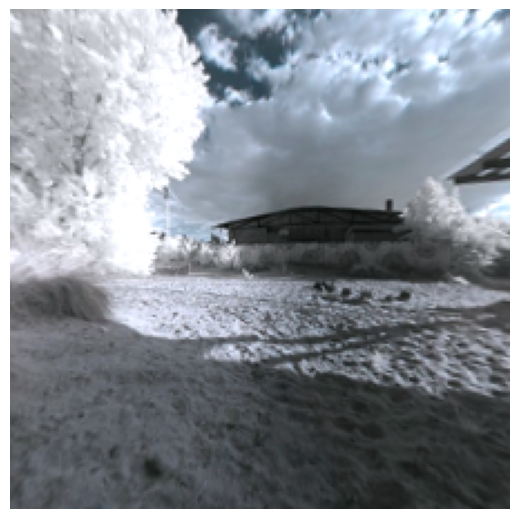

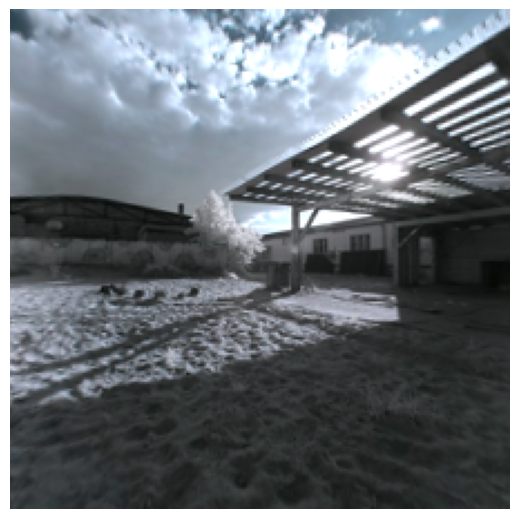

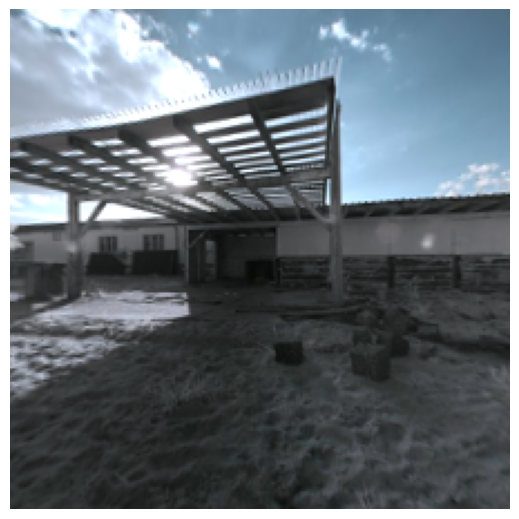

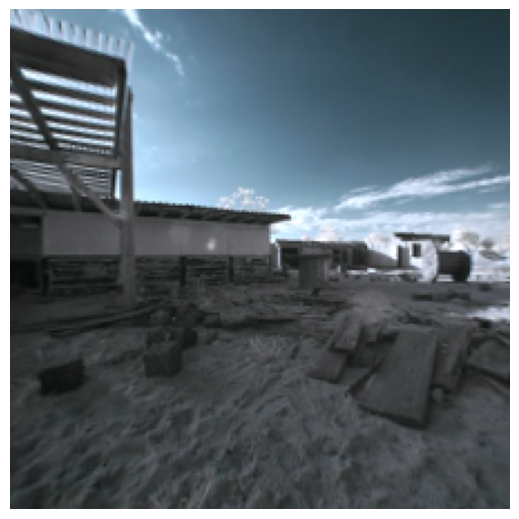

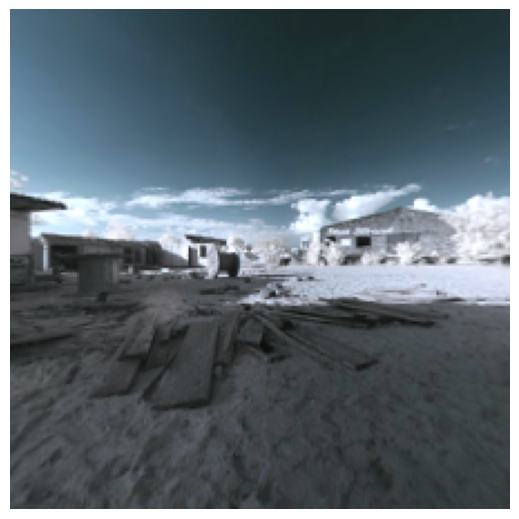

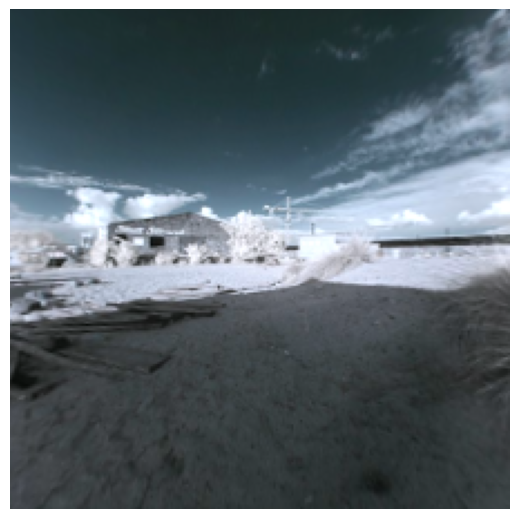

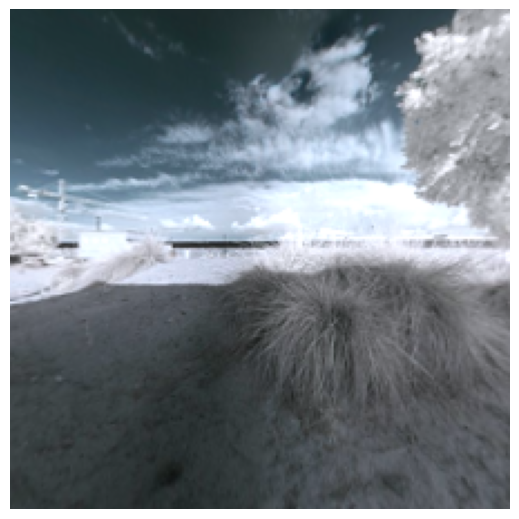

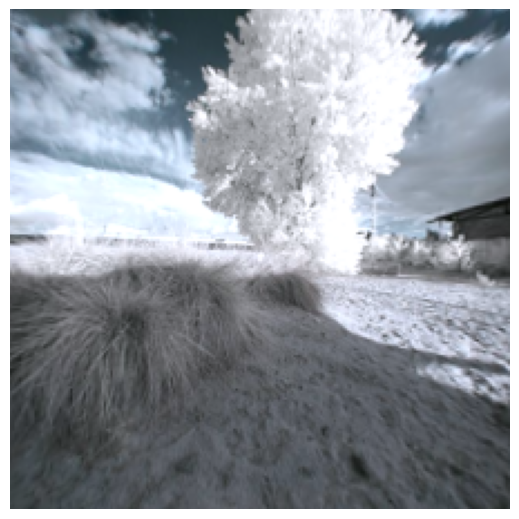

In [ ]:
from train_vlm import QuIC360Dataset
from transformers import AutoProcessor, AutoTokenizer
import numpy as np
dataset = QuIC360Dataset(
    csv_file="data/quic360/downtest.csv",
    image_processor= AutoProcessor.from_pretrained("facebook/dinov2-small"),
    tokenizer=AutoTokenizer.from_pretrained("Qwen/Qwen3-0.6B"),
    image_size=[224, 224],
    max_length=128,
    do_crop=True,
    fov=90,
    overlap_ratio=0.5,
)
sample = dataset[0]
for i, img in enumerate(sample["pixel_values"]):
    save_image_as_pil(img, f"")

image_size: (448, 896)
[train] img_size=(448, 896)  do_crop=True
Input sequence:
<|im_start|>system
You are a helpful assistant. Describe this image.<|im_end|>
<|im_start|>user
location <image><image><|im_end|>
<|im_start|>assistant
<think>

</think>

A construction business that was operating in a dessert area, the company now looks to be abandon,   In the distance a crane stands watch over the business.<|im_end|>
<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endofte

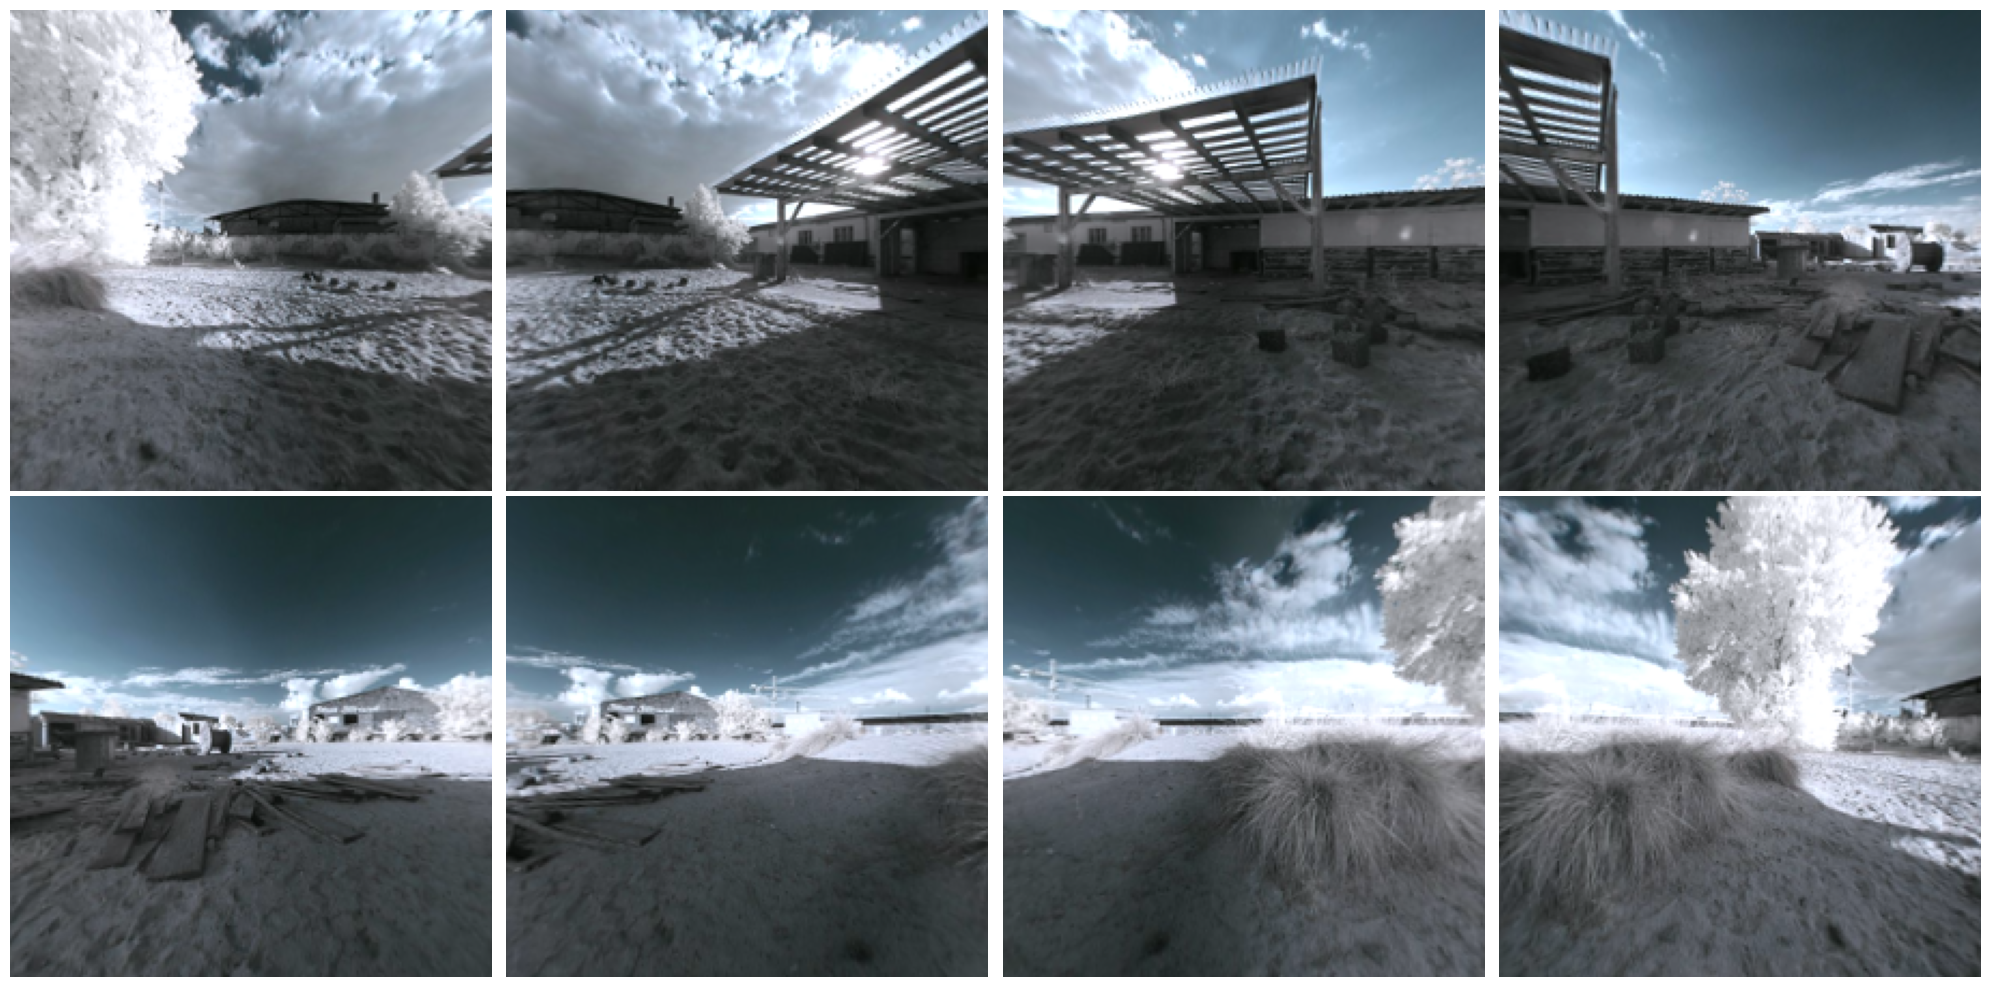

(tensor([151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
          60785,    419,   2168,     13, 151645,    198, 151644,    872,    198,
           2527,    366,   1805,   1784,   1805,     29, 151645,    198, 151644,
          77091,    198, 151667,    271, 151668,    271,     32,   8086,   2562,
            429,    572,  10350,    304,    264,  42749,   3082,     11,    279,
           2813,   1431,   5868,    311,    387,  15313,     11,    256,    758,
            279,   6010,    264,  72947,  13352,   3736,    916,    279,   2562,
             13, 151645,    198, 151643, 151643, 151643, 151643, 151643, 151643,
         151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
         151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
         151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
         151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
         151643, 151643, 151

In [ ]:

sample = dataset[0]
visualize_images(sample["pixel_values"], titles=[sample["question"]])
sample["input_ids"], sample["attention_mask"], sample["labels"]

In [6]:
# No Crop
dataset = QuIC360Dataset(data_dir/"downtest.csv", "Salesforce/blip2-opt-2.7b", image_size=[224,224],max_length=30, split="valid",)
loader = DataLoader(dataset, batch_size=4, shuffle=False)
batch = next(iter(loader))
sample = batch
# Example usage
visualize_images(batch["pixel_values"][0], titles=batch["question"])

TypeError: QuIC360Dataset.__init__() missing 1 required positional argument: 'tokenizer'

In [7]:
# No Crop
dataset = QuIC360Dataset(data_dir/"downtest.csv", "Salesforce/blip2-opt-2.7b" , max_length=30, image_size=[224,224],do_crop = True,fov=90,overlap_ratio=0.5,split="valid")
loader = DataLoader(dataset, batch_size=4, shuffle=False)
batch = next(iter(loader))
sample = batch
# Example usage
visualize_images(batch["pixel_values"][0], titles=batch["question"])
print(batch["pixel_values"].shape)
print(batch["input_ids"].shape)
print(batch["attention_mask"].shape)
print(batch["labels"].shape)

TypeError: QuIC360Dataset.__init__() missing 1 required positional argument: 'tokenizer'

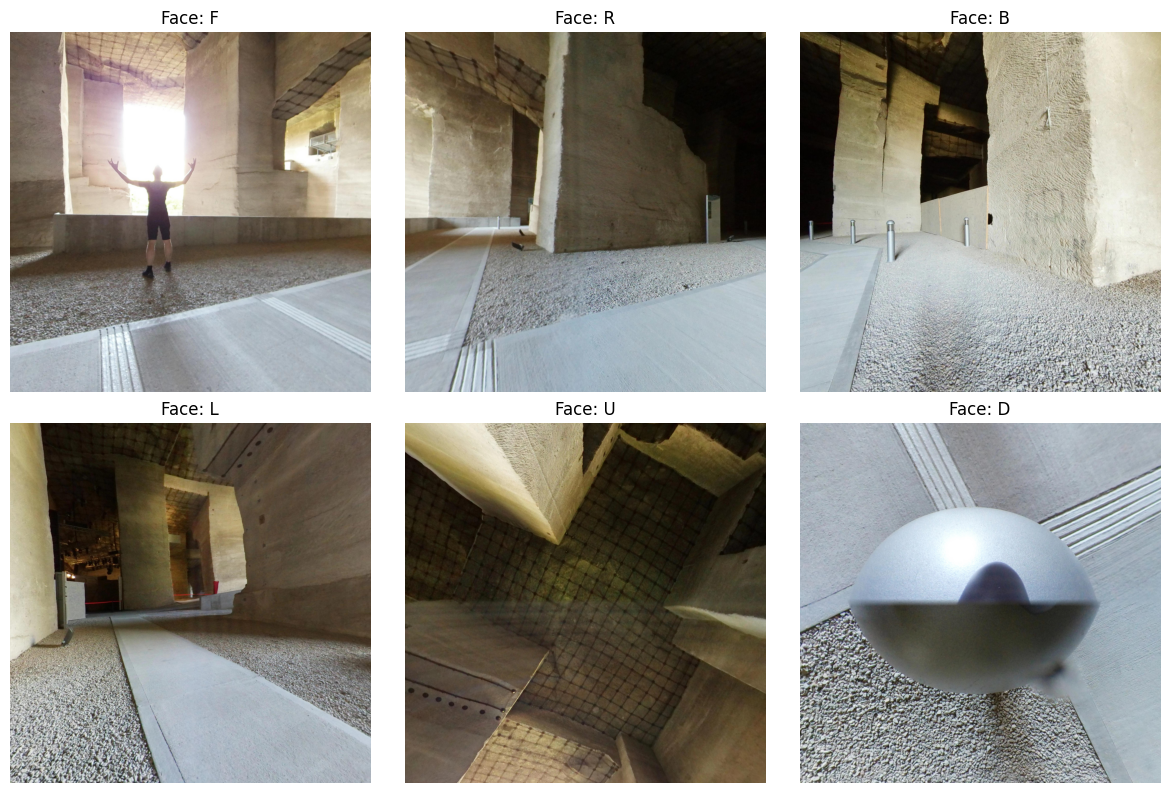

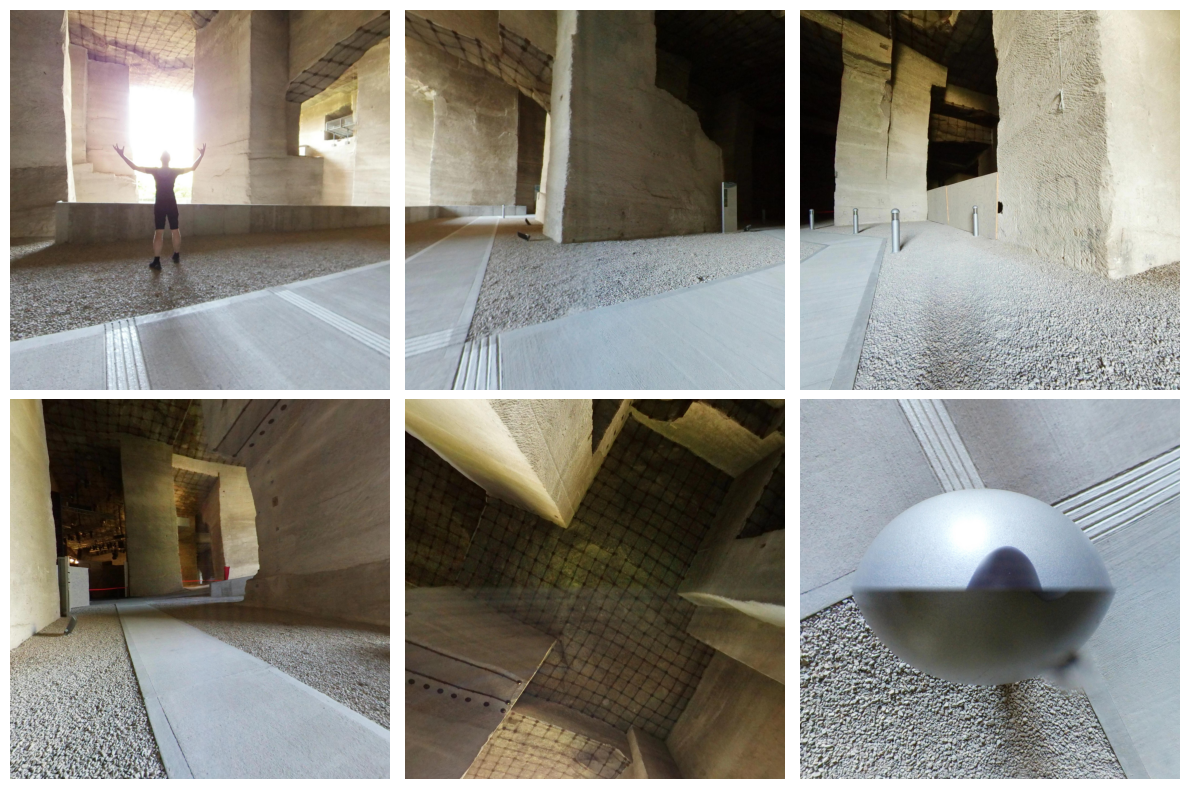

In [ ]:
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image

import numpy as np
from py360convert import  e2c, e2p

def split_360_to_cubemap_views(equirect_img, fov=90, overlap_ratio=0.5):
    """
    360도 이미지를 큐브맵으로 변환한 후 원하는 FOV와 overlap으로 자른 이미지들을 반환
    
    Args:
        equirect_img: numpy array, 360도 이미지 (H:W = 1:2)
        fov: 시야각 (기본값 90도)
        overlap_ratio: 겹침 비율 (기본값 0.5)
    
    Returns:
        views: 잘라진 이미지들의 리스트
    """
    return 0
    # 입력 이미지 크기 확인
    h, w = equirect_img.shape[:2]
    assert w == 2 * h, "Input image must have 1:2 aspect ratio (360° image)"

url = "https://live.staticflickr.com/65535/50333141271_afd4f08f1c_o.jpg"
response = requests.get(url)
equirect_img = np.array(Image.open(BytesIO(response.content)).convert('RGB'))
overlap_ratio =0.5    
fov = 90
h, w = equirect_img.shape[:2]
# 큐브맵 한 면의 크기 결정 (정사각형에 가깝게)
face_size = h // 2

# Equirectangular -> CubeMap 변환
cubemap = e2c(equirect_img, face_w=face_size, mode='bilinear', cube_format='dict')

# FOV 90도에 맞는 출력 이미지 크기 계산
output_size = int(face_size * np.tan(np.radians(fov/2)) * 2)

# overlap 계산
overlap_pixels = int(output_size * overlap_ratio)
step_size = output_size - overlap_pixels

views = [v for v in cubemap.values()]  # 리스트 컴프리헨션 사용

# rlfb 합치기

    

# Face 시각화
plt.figure(figsize=(12, 8))
for i, face_key in enumerate(cubemap):
    ax = plt.subplot(2, 3, i + 1)
    ax.imshow(cubemap[face_key])
    ax.set_title(f"Face: {face_key}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# 전체 시각화
plt.figure(figsize=(12, 8))
for i, view in enumerate(views):
    ax = plt.subplot(2, 3, i + 1)
    ax.imshow(view)
    ax.axis("off")
plt.tight_layout()
plt.show()